# Setting Up Environment

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords


from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import Flatten, Embedding, GlobalMaxPooling1D, Conv1D, LSTM
from sklearn.model_selection import train_test_split

# Loading Dataset

In [3]:
crude_oil_news = pd.read_csv('data.csv')

In [4]:
crude_oil_news.shape

(10289, 2)

In [5]:
crude_oil_news.head(5)

,News,Prediction
0,nigerian national petroleum corp has cut the ...,INCREASE
1,shares of seismic services company pgs which ...,INCREASE
2,the russian budget will get a boost of at lea...,INCREASE
3,oil giant bpa��s eastern trough area project ...,INCREASE
4,oil prices fell on thursday pressured by a ri...,INCREASE


In [6]:
crude_oil_news.isnull().values.any()

False

<AxesSubplot:xlabel='Prediction', ylabel='count'>

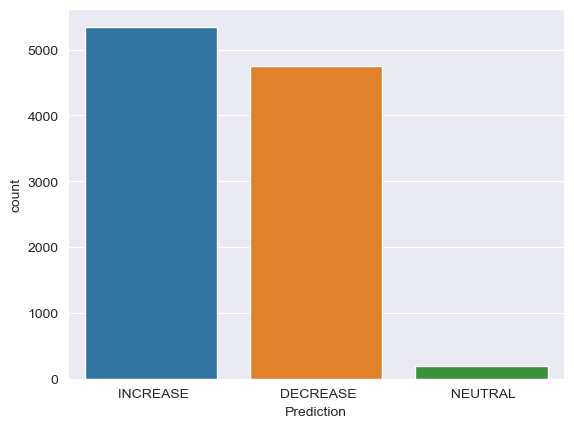

In [7]:
import seaborn as sns
sns.countplot(x='Prediction', data=crude_oil_news)

# Data Preprocessing

In [8]:
crude_oil_news['News'][2]

' the russian budget will get a boost of at least 1 trillion roubles 16 billion from changes to taxation in oil production and refining in the next six years two government officials said on thursdaythey told a news brieing at the energy ministry that the government hopes to get as much as 13 trillion roubles in additional reveneus from the tax changes that would help state coffers at time when the energy ministry says it expects oil refining volumes to decrease in russia by 1517 million tonnes starting from 20212022russia has been tweaking its oil taxation in a move known as the tax manoeuvre by raising mineral extraction tax and gradually reducing exporting duty for selling oil and oil products abroadalexey sazanov the head of the tax department in the finance ministry said even if the price of oil averages 40 per barrel the budget will get an extra 1 trillion roubles in 2019 2024the finance ministry sees budget revenues at 171 trillion roubles in 2018 rising to 199 trillion in 2019t

In [9]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neram\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocessing_text(sen):
    sentence = sen.lower()

    sentence = remove_tags(sentence)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r'\s+', ' ', sentence)

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [12]:
X = []
sentences = list(crude_oil_news['News'])
for sen in sentences:
    X.append(preprocessing_text(sen))

In [13]:
y = crude_oil_news['Prediction']

y = np.array(list(map(lambda x: 1 if x==" INCREASE" else 0, y)))
np.asarray(y)


array([1, 1, 1, ..., 0, 0, 0])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Preparing Embedding Layer

In [16]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [17]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

98169

In [18]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [20]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [21]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix.shape

(98169, 100)

# Model Training

## Simple Neural Network

In [23]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [24]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9816900   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,826,901
Trainable params: 10,001
Non-trainable params: 9,816,900
_________________________________________________________________
None


In [25]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
52/52 [==============================] - 1s 8ms/step - loss: 0.7695 - acc: 0.5006 - val_loss: 0.7535 - val_acc: 0.5124
Epoch 2/50
52/52 [==============================] - 0s 5ms/step - loss: 0.6212 - acc: 0.6552 - val_loss: 0.7464 - val_acc: 0.5009
Epoch 3/50
52/52 [==============================] - 0s 5ms/step - loss: 0.5529 - acc: 0.7262 - val_loss: 0.7664 - val_acc: 0.5082
Epoch 4/50
52/52 [==============================] - 0s 5ms/step - loss: 0.4960 - acc: 0.7865 - val_loss: 0.7877 - val_acc: 0.5173
Epoch 5/50
52/52 [==============================] - 0s 5ms/step - loss: 0.4595 - acc: 0.8162 - val_loss: 0.8013 - val_acc: 0.5173
Epoch 6/50
52/52 [==============================] - 0s 5ms/step - loss: 0.4198 - acc: 0.8521 - val_loss: 0.8201 - val_acc: 0.5161
Epoch 7/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3915 - acc: 0.8697 - val_loss: 0.8529 - val_acc: 0.5258
Epoch 8/50
52/52 [==============================] - 0s 4ms/step - loss: 0.3673 - acc: 0.88

In [26]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

65/65 [==============================] - 0s 2ms/step - loss: 1.6887 - acc: 0.5015


In [27]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 1.6887043714523315
Test Accuracy: 0.5014577507972717


In [28]:
prediction = snn_model.predict(X_test)

65/65 [==============================] - 0s 2ms/step


In [29]:
prediction

array([[0.47354877],
       [0.03995787],
       [0.44111574],
       ...,
       [0.0176937 ],
       [0.999979  ],
       [0.1901873 ]], dtype=float32)

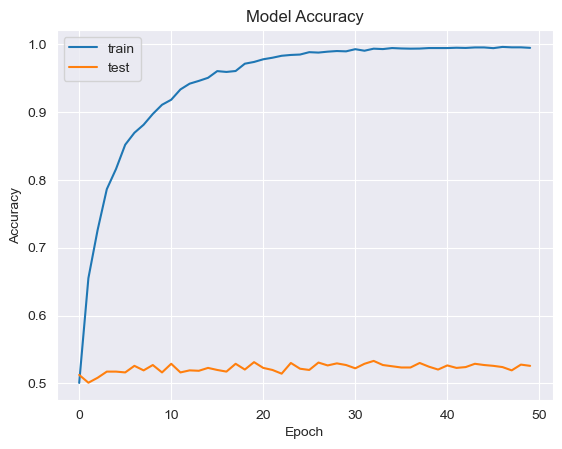

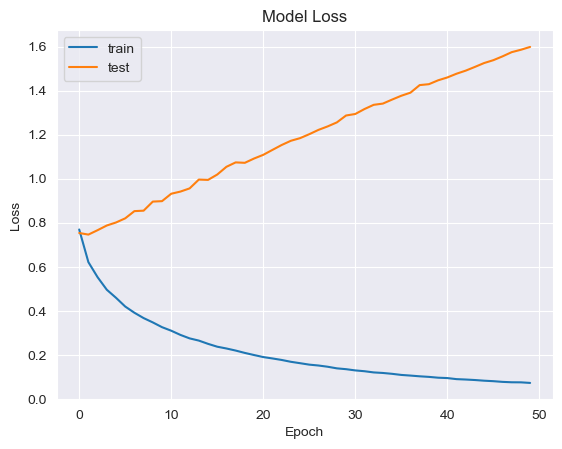

In [30]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [31]:
from keras.layers import Dropout

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())

# Add additional layers
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(1, activation='sigmoid'))

In [32]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9816900   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                      

In [33]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
52/52 [==============================] - 2s 29ms/step - loss: 0.7137 - acc: 0.5009 - val_loss: 0.6920 - val_acc: 0.5313
Epoch 2/50
52/52 [==============================] - 1s 27ms/step - loss: 0.6924 - acc: 0.5257 - val_loss: 0.6953 - val_acc: 0.5167
Epoch 3/50
52/52 [==============================] - 1s 28ms/step - loss: 0.6884 - acc: 0.5407 - val_loss: 0.6909 - val_acc: 0.5264
Epoch 4/50
52/52 [==============================] - 1s 28ms/step - loss: 0.6795 - acc: 0.5744 - val_loss: 0.6914 - val_acc: 0.5282
Epoch 5/50
52/52 [==============================] - 1s 28ms/step - loss: 0.6557 - acc: 0.6229 - val_loss: 0.6996 - val_acc: 0.5313
Epoch 6/50
52/52 [==============================] - 1s 29ms/step - loss: 0.6032 - acc: 0.6815 - val_loss: 0.7113 - val_acc: 0.5258
Epoch 7/50
52/52 [==============================] - 1s 28ms/step - loss: 0.5037 - acc: 0.7719 - val_loss: 0.7581 - val_acc: 0.5258
Epoch 8/50
52/52 [==============================] - 1s 26ms/step - loss: 0.3718 - a

In [34]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

65/65 [==============================] - 0s 4ms/step - loss: 3.3602 - acc: 0.5326


In [35]:
print("Test Score:", score[0])

Test Score: 3.3602330684661865


In [36]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.532555878162384


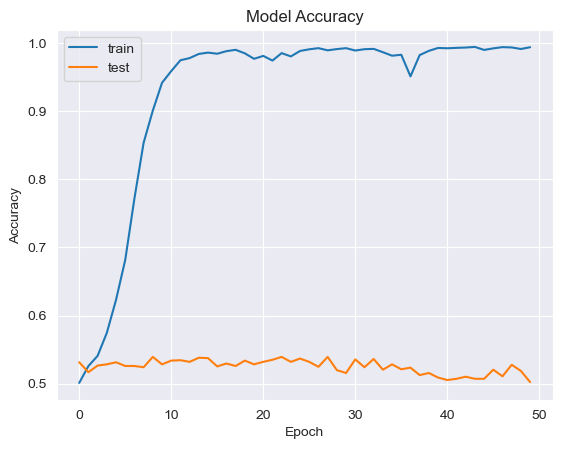

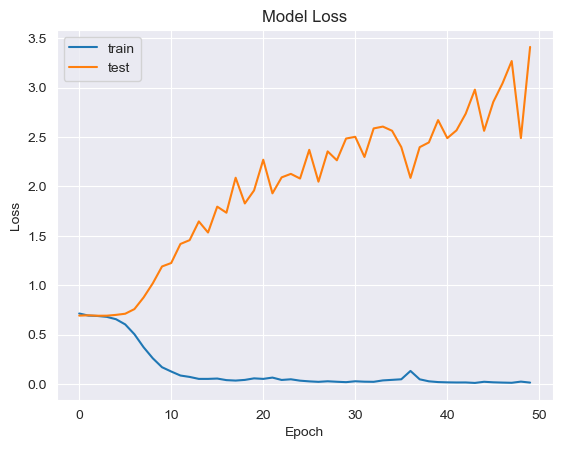

In [37]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
